# Notes

* Problem statment does not suggest device independence: these could be networked or interdependent systems, e.g. ordering.
* Failure class is HEAVILY imbalanced; modeling is prone to finding local optima that explain the majority class.
* [During failure, attributes 2, 4, 7, and 8 report much higher values than normal. This is not true of 1, 3, 5, 6, and 9](#failhard)
* [a1 and a6 are very unique](#uniqueness)
* [No duplicate data and no missing values](#missing)
* [Events may have natural ordering that needs to be preserved](#ordered)
* [Devices appear to come in types/classes](#deviceclasses)
* Attributes look to be aggregates except for a1
* [a2 & a4 ramp-up before failure, and looks like a7 spikes quickly too](#correlation)
* Some devices go through "servicing" where aggregate value drops
* [a3 & a9 are weakly positively correlated](#correlation)
* [a7 & a8 are perfectly positively correlated... because they are identical](#a7a8)
* [a7 appears to be critical in predicting failure in a naive model](#naivemodel)

# Setup

## Imports

In [1]:
# mute warnings
import warnings
warnings.filterwarnings('ignore')

# science
import scipy as sp
import numpy as np
import pandas as pd
import featuretools as ft
import xgboost as xgb
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# system
import random
import hashlib
import pickle
import tempfile
import time

# visuals
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from IPython import display

# options
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
sns.set_style('whitegrid')
sns.set_context('notebook')
sns_cmap = sns.diverging_palette(10, 220, sep=80, n=5)
pd.set_option('display.max_colwidth', -1)

# in case nb needs to be re-run
try:
    %load_ext autoreload
except:
    %reload_ext autoreload
%autoreload 2

## Functions

In [2]:
def load_data(filename):
    '''
    Load a generic CSV file into a pandas dataframe
    '''
    df = pd.read_csv(filename, escapechar='\\', encoding='utf-8')
    df['uuid'] = df.apply(lambda x: hashlib.md5(str(x.values).encode('utf-8')).hexdigest(), axis=1)
    assert sum(df.set_index('uuid').index.duplicated()) == 0, 'Error loading data: Hash collision; duplicate data'
    return df

In [3]:
def calculate_nan_values(orig_df):
    df = orig_df.copy()
    df = df.isna().sum(axis=0).reset_index()
    df.columns = ['column_name', 'na_count']
    df['na_ratio'] = df['na_count'] / orig_df.shape[0]
    df = df.loc[df['na_ratio'] > 0]
    df = df.sort_values(by='na_ratio')
    return df

In [4]:
def calculate_null_values(orig_df):
    df = orig_df.copy()
    df = df.isnull().sum(axis=0).reset_index()
    df.columns = ['column_name', 'null_count']
    df['null_ratio'] = df['null_count'] / orig_df.shape[0]
    df = df.loc[df['null_ratio'] > 0]
    df = df.sort_values(by='null_ratio')
    return df

In [5]:
def value_limits(df, field, upper_bound=99, lower_bound=1):
    upper_limit = np.percentile(df[field].values, upper_bound)
    lower_limit = np.percentile(df[field].values, lower_bound)
    return upper_limit, lower_limit

In [6]:
def visualize_correlations(df, fields):

    # keep a copy
    df = df.copy()

    # correlation coefficient of each column
    for field in fields:
        x_cols = [col for col in df.columns
                  if col != field and (df[col].dtype=='float64' or df[col].dtype=='int64')]
        labels = []
        values = []
        for col in x_cols:
            labels.append(col)
            values.append(
                np.corrcoef(df[col].values, df[field].values)[0, 1])

        # create dataframe for corr coeffs
        corr_df = pd.DataFrame({'col_labels': labels, 'corr_values': values})
        corr_df = corr_df.sort_values(by='corr_values')

        ind = np.arange(len(labels))
        fig, ax = plt.subplots(figsize=(12, 4))
        rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
        ax.set_yticks(ind)
        ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
        ax.set_xlabel('correlation coefficient')
        ax.set_title('Correlations with {}'.format(field))
        ax.set_xlim(-1, 1)
        plt.show()

In [7]:
def visualize_values(df, fields):
    
    # keep a copy
    df = df.copy()

    # iterate over fields
    for field in fields:

        # get limits of data
        ulimit, llimit = value_limits(df, field)
        print('###################')
        print('Working on field {}'.format(field))
        print('Upper limit: {:.3f}'.format(ulimit))
        print('Lower limit: {:.3f}'.format(llimit))

        # plot the ordered values for field
        plt.figure(figsize=(12, 8))
        plt.scatter(range(df.shape[0]), np.sort(df[field].values))
        plt.xlabel('index', fontsize=12)
        plt.ylabel(field, fontsize=12)
        plt.show()

        # plot histo of values
        sns.distplot(df[field].values, bins=50, kde=True, norm_hist=True)
        plt.xlabel(field, fontsize=12)
        plt.show()

In [8]:
def save_hdf5(df, hdf_file, table_name, format=None):
    if format is not None:
        df.to_hdf(
            hdf_file,
            table_name,
            mode='w',
            format=format,
            data_columns=True,
            complevel=9,
            complib='blosc:lz4')
    else:
        df.to_hdf(
            hdf_file,
            table_name,
            mode='w',
            data_columns=True,
            complevel=9,
            complib='blosc:lz4')

In [56]:
def train_xgb_model(X_train, y_train, params, kfolds=10, random_seed=7):

    # setup
    random.seed(random_seed)
    np.random.seed(random_seed)

    # isolate train features
    X_train = X_train.values
    y_train = y_train.astype(int).values
    
    # stratified k-fold
    skf = StratifiedKFold(n_splits=kfolds, random_state=42, shuffle=False)
    best_score = 0
    best_model = None
    for i, (train_index, cv_index) in enumerate(skf.split(X_train, y_train)):
        print('Working on k-fold {}...'.format(i))
        
        # split data
        print('Splitting data')
        X_ktrain, X_kcv = X_train[train_index], X_train[cv_index]
        y_ktrain, y_kcv = y_train[train_index], y_train[cv_index]
        
        # Convert our data into XGBoost format
        print('Converting data to xgb format')        
        d_train = xgb.DMatrix(X_ktrain, label=y_ktrain, feature_names=feature_names)
        d_cv    = xgb.DMatrix(X_kcv, label=y_kcv, feature_names=feature_names)
        watchlist = [(d_train, 'train'), (d_cv, 'cv')]

        # train the model
        print('Modeling')
        model = xgb.train(params, d_train, num_boost_round=3000,
                          evals=watchlist, #feval=cohen_kappa_scorer,
                          early_stopping_rounds=300, verbose_eval=200)
        if model.best_score > best_score:
            best_score = model.best_score
            best_model = model
            model.save_model('xgboost_tuned.model')
        print('Done.')
    
    # testing
    return best_model

In [ ]:
def cohen_kappa_scorer(preds, dmatrix):
    y = dmatrix.get_label()
    cohen_kappa_score(preds, y)
    return 'kappa', score

In [11]:
def sensitivity(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_test, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [12]:
def specificity(y_test, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_test) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_test, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Data Ingest

In [13]:
# load data
faults_df = load_data("device_failure.csv")

In [14]:
# see a sample
faults_df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure,uuid
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0,5646eb712abba53b99fd8b8152c8f503
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0,4eff5953a2d3610d43197ada2ea8002d
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0,f9b3e1204591b513e0f1aa53abd65dd9
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0,4c5c11b2f5e33fc3626c669b3ecb45d3
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0,a742b325beb173c3827e77ade95c157d


In [15]:
# rename columns for less typing
faults_df.columns = faults_df.columns.str.replace("attribute", "a")

In [16]:
# odd date format, did load reformat?
!head device_failure.csv

In [17]:
# basic summary for any obvious weirdness
faults_df.describe()

,date,a1,a2,a3,a4,a5,a6,a7,a8,a9,failure
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,15106.222798,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524,0.000851
std,78.412061,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623,0.029167
min,15001.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,15040.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000,0.000000
50%,15086.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000,0.000000
75%,15168.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000,0.000000
max,15306.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000,1.000000


This data set appears to have attributes that are either "codes" or aggregates. The min/max and stddev for each is large, so there's a spread. If these are codes, one-hot encoding will be... tough.

# EDA

## QA/QC

In [18]:
# double-check problem statement, one device per day?
check = faults_df.date.astype(str) + faults_df.device.astype(str)
assert len(check) == len(check.drop_duplicates()), 'More than one device per day'

In [19]:
# inspect data types
dtype_df = faults_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,date,int64
1,device,object
2,a1,int64
3,a2,int64
4,a3,int64
5,a4,int64
6,a5,int64
7,a6,int64
8,a7,int64
9,a8,int64


In [20]:
# inspect uniqueness
uniqueness_df = pd.DataFrame(faults_df.nunique()).reset_index()
uniqueness_df.columns = ["column", "num_unique"]
uniqueness_df['perc_unique'] = uniqueness_df.num_unique.apply(lambda x: x/len(faults_df))
uniqueness_df

,column,num_unique,perc_unique
0,date,304,0.002442
1,device,1168,0.009382
2,a1,123878,0.995052
3,a2,558,0.004482
4,a3,47,0.000378
5,a4,115,0.000924
6,a5,60,0.000482
7,a6,44838,0.360162
8,a7,28,0.000225
9,a8,28,0.000225


A1 is very unique: device identifier? Can't be. Must be a daily value. <a id="uniqueness"></a>

In [21]:
# nulls
calculate_null_values(faults_df)

,column_name,null_count,null_ratio


In [22]:
# nan's (just to be sure)
calculate_nan_values(faults_df)

,column_name,na_count,na_ratio


###################
Working on field date
Upper limit: 15286.000
Lower limit: 15002.000


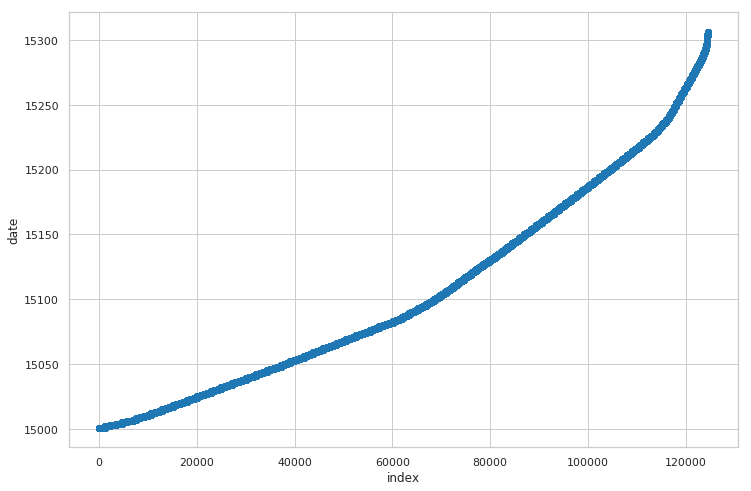

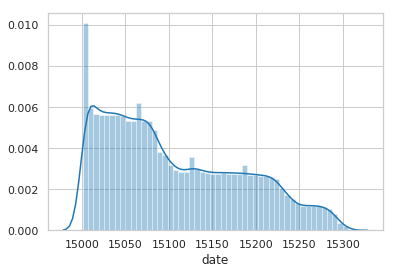

###################
Working on field a1
Upper limit: 241791145.360
Lower limit: 2401025.280


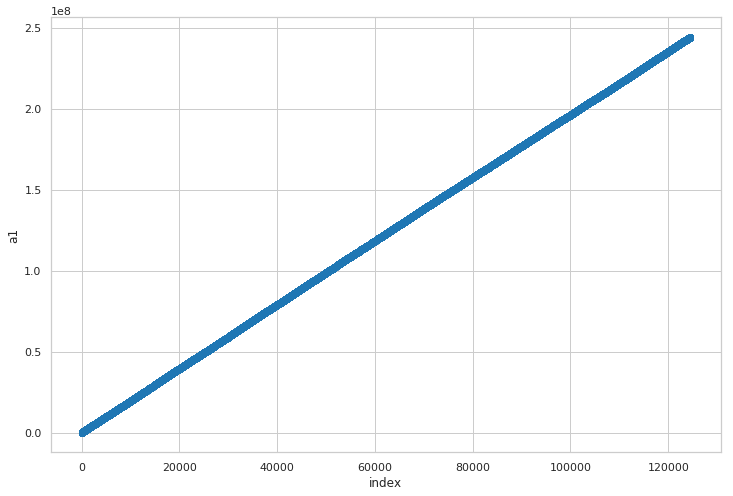

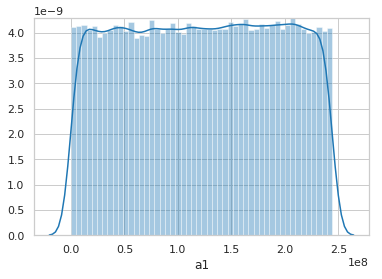

###################
Working on field a2
Upper limit: 2664.000
Lower limit: 0.000


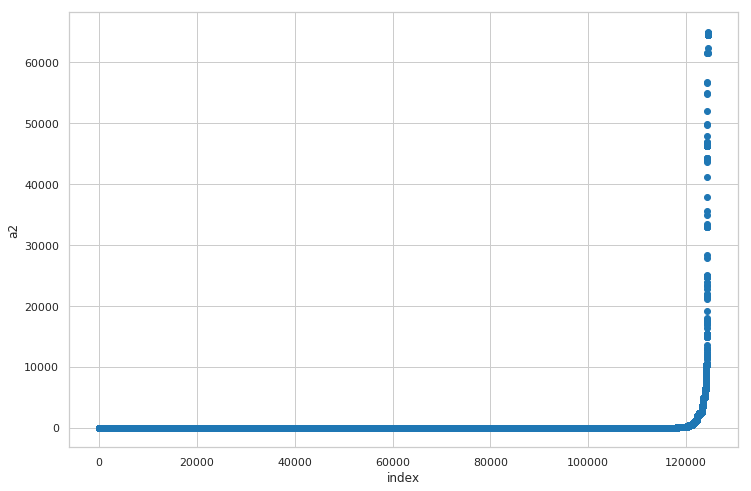

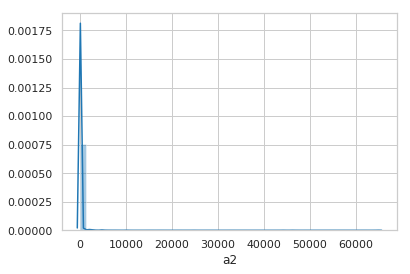

###################
Working on field a3
Upper limit: 107.000
Lower limit: 0.000


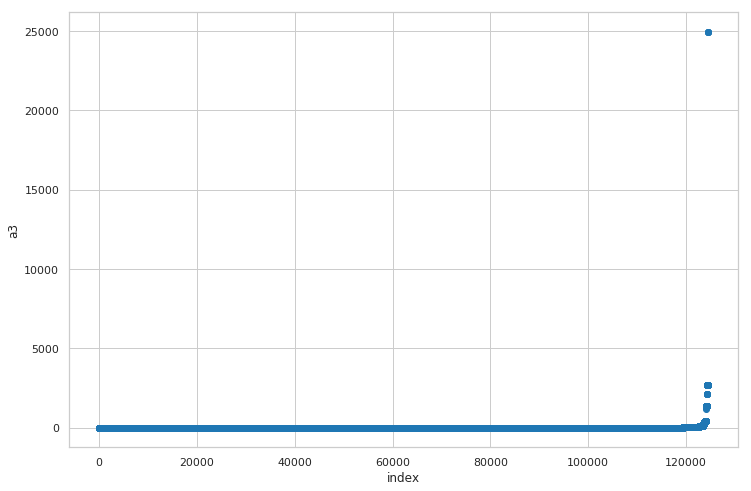

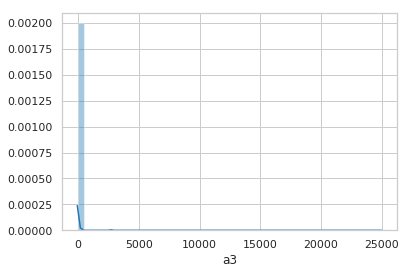

###################
Working on field a4
Upper limit: 25.000
Lower limit: 0.000


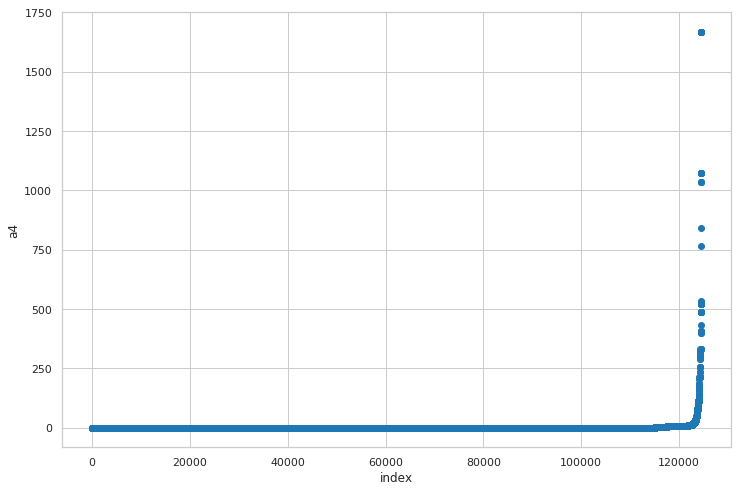

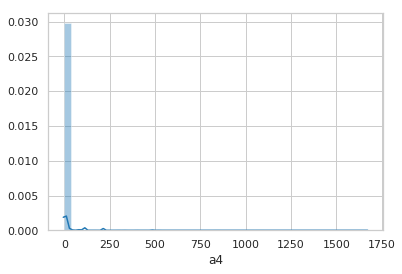

###################
Working on field a5
Upper limit: 92.000
Lower limit: 4.000


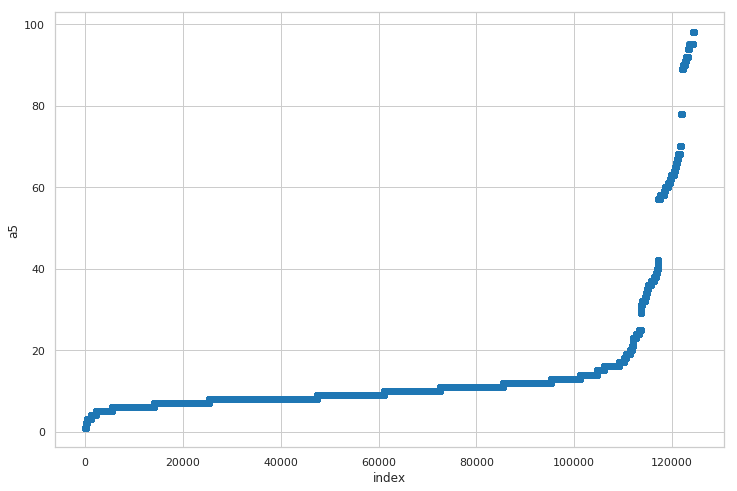

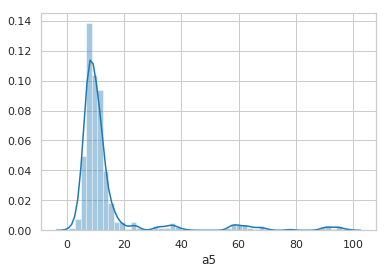

###################
Working on field a6
Upper limit: 501012.490
Lower limit: 26.000


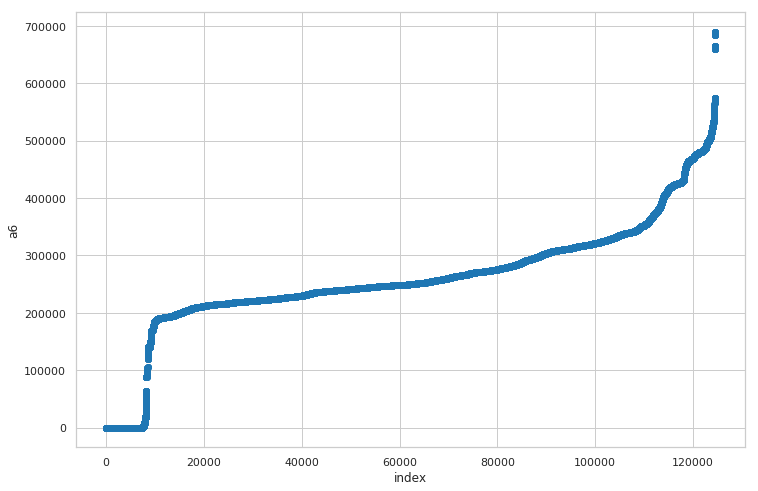

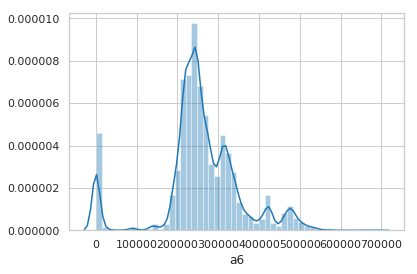

###################
Working on field a7
Upper limit: 8.000
Lower limit: 0.000


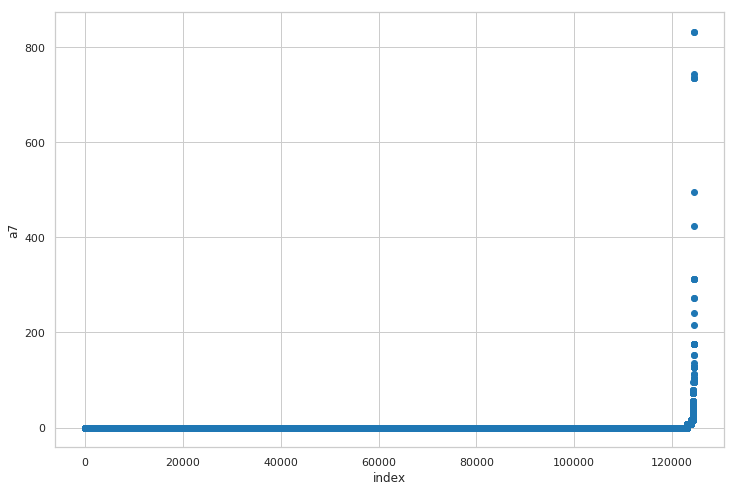

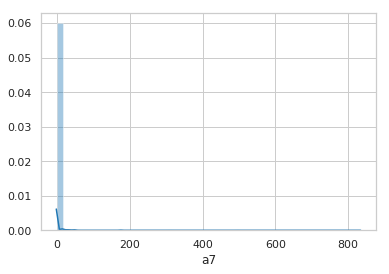

###################
Working on field a8
Upper limit: 8.000
Lower limit: 0.000


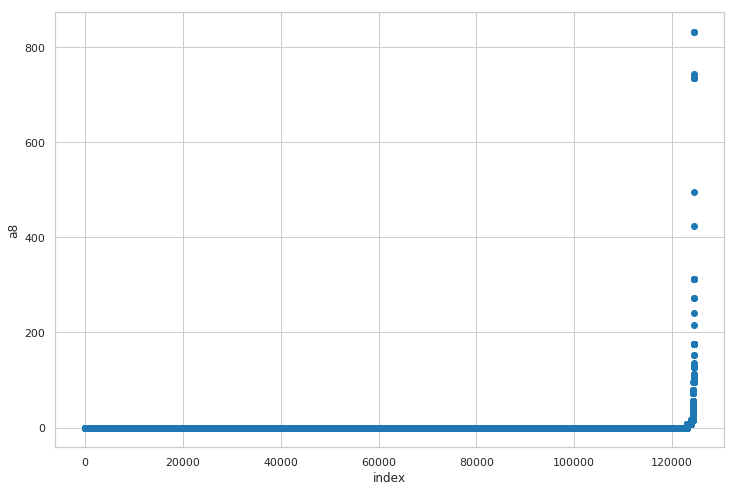

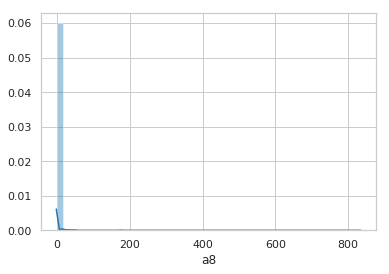

###################
Working on field a9
Upper limit: 155.000
Lower limit: 0.000


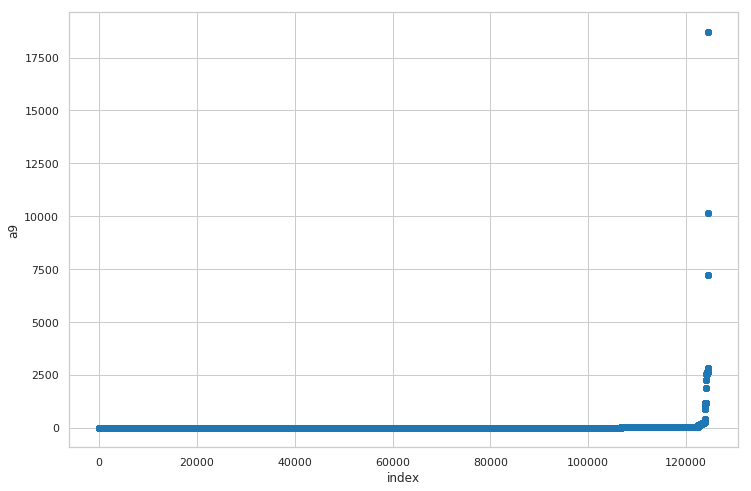

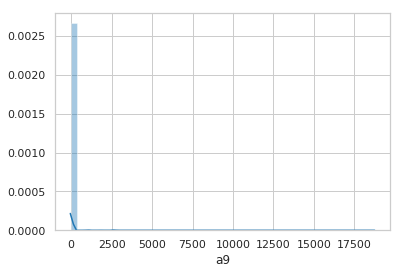

###################
Working on field failure
Upper limit: 0.000
Lower limit: 0.000


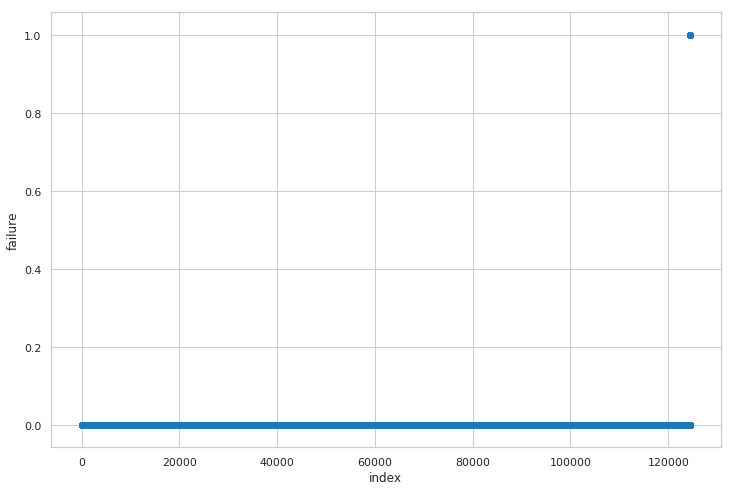

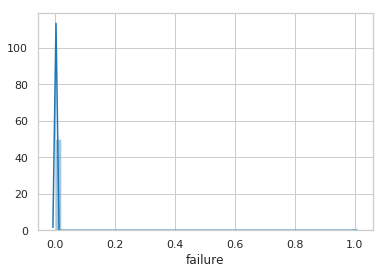

In [23]:
# visualize column values
fields = [c for c in faults_df.columns if faults_df[c].dtype == 'int64']
visualize_values(faults_df, fields)

Some attributes have orders of magnitude higher values than others within same category. Must have units of measure.

In [25]:
cols = faults_df.filter(regex='^a').columns.tolist()
temp = faults_df[cols]

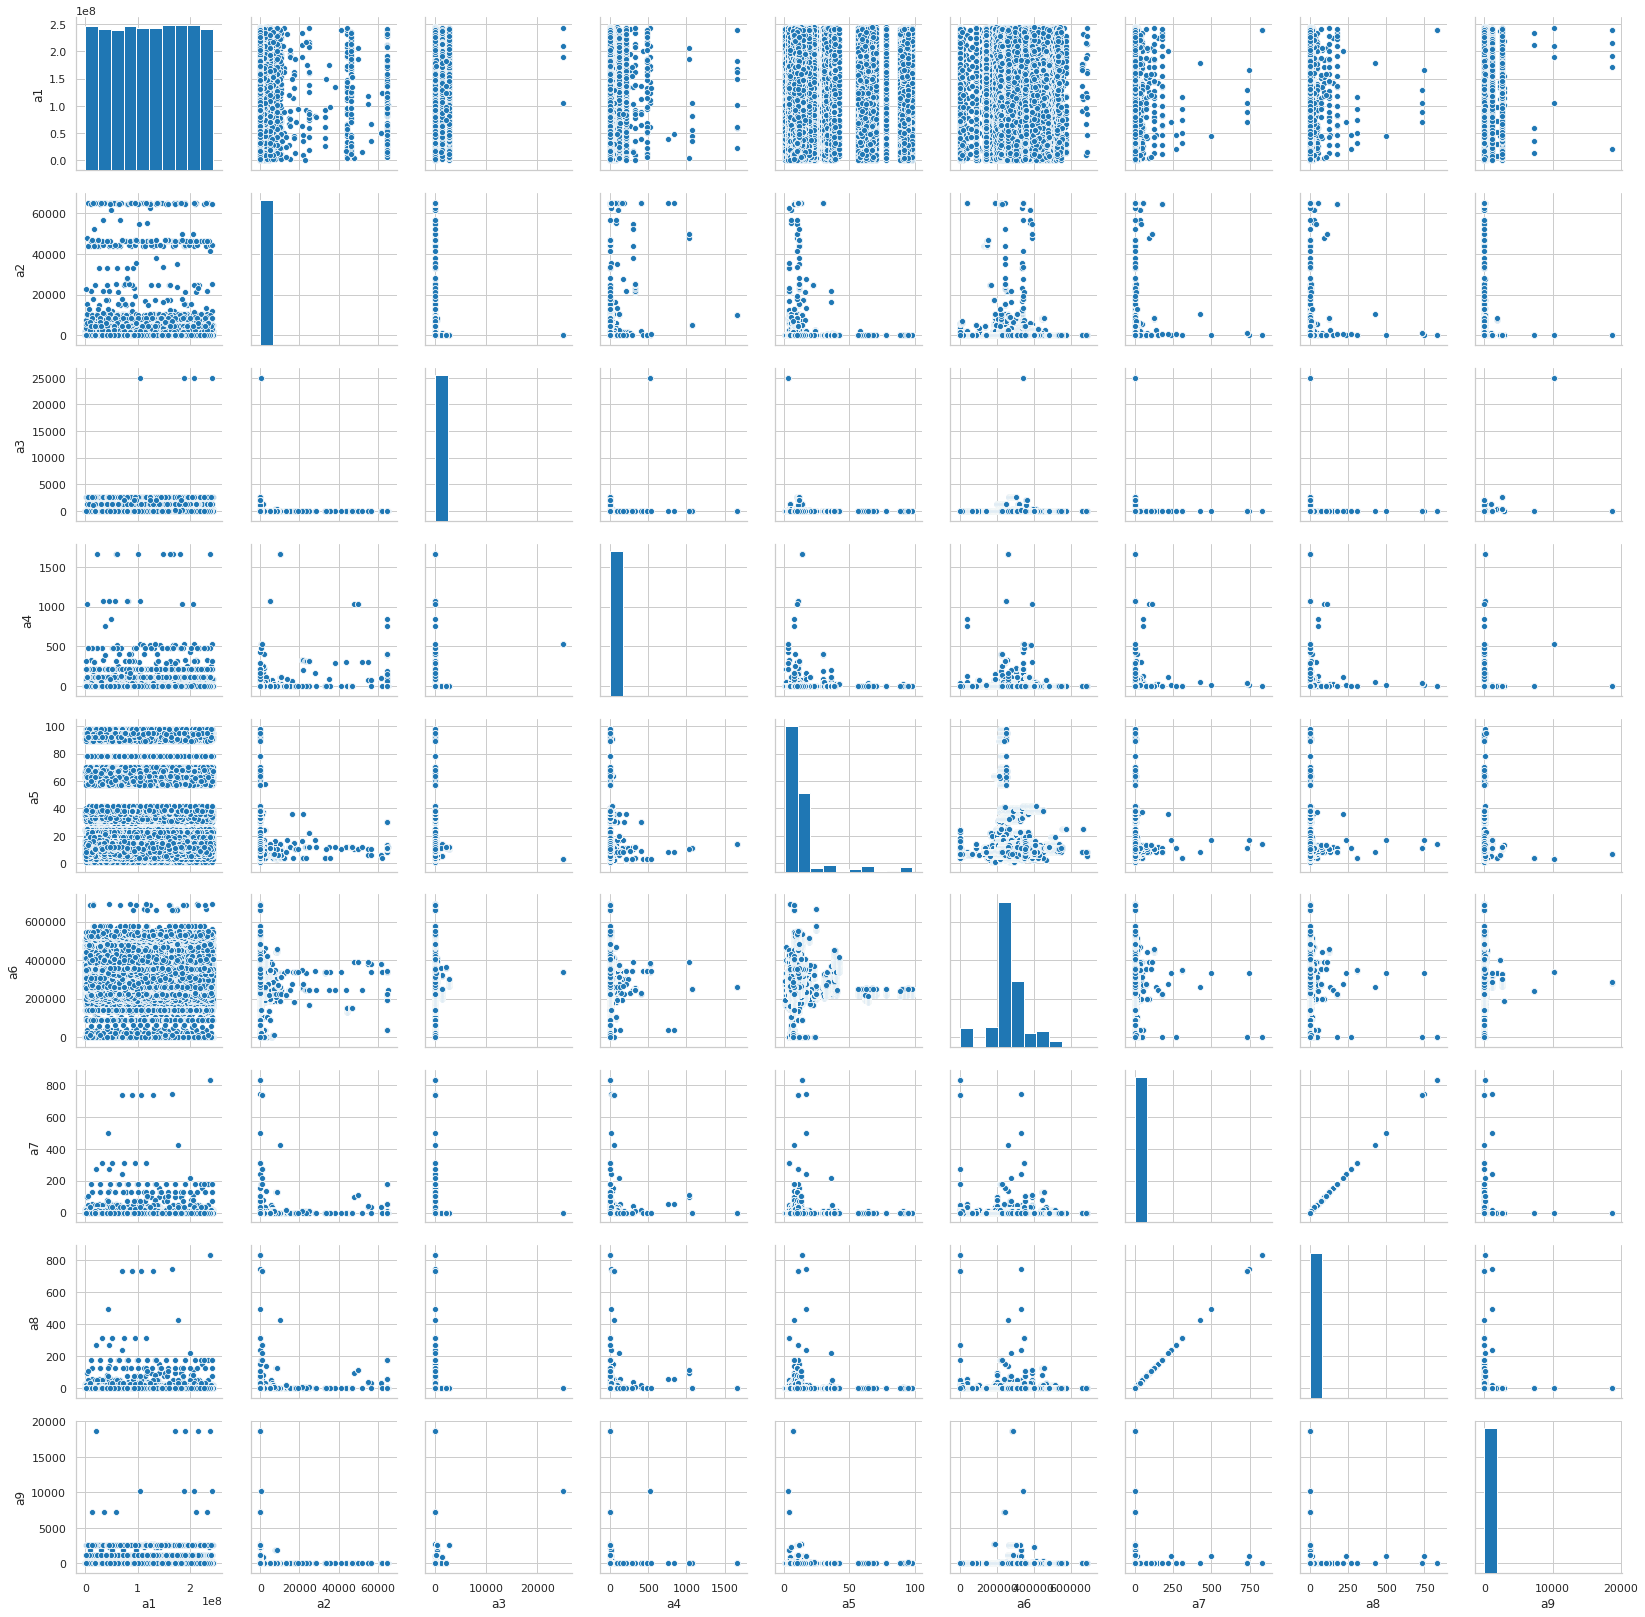

In [26]:
sns.pairplot(temp);

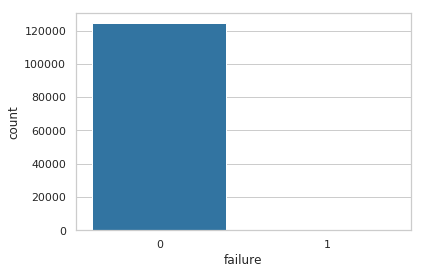

In [27]:
sns.countplot(x="failure", data=faults_df)

Yikes, this is an extreme example of imbalanced classes.

## Classes

In [24]:
# summary count of classes
100.*faults_df.groupby('failure').failure.count()/len(faults_df)

failure
0    99.914855
1    0.085145 
Name: failure, dtype: float64

"Extreme" is putting it lightly: 99.91% of the time, the data indicates non-failure. **Model #1**: Always predict 'non-failure', you'll be right most of the time :)

In [26]:
# summarize by class
temp = faults_df.filter(regex='^a|failure')
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(temp) 
temp.loc[:,:] = scaled_values
temp_melt = pd.melt(temp, "failure", var_name="measurement")

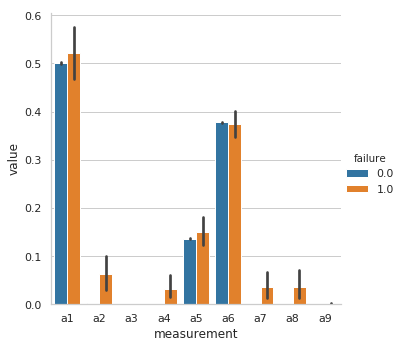

In [27]:
sns.catplot(x="measurement", y="value", hue="failure", kind="bar", data=temp_melt);

Do some attributes have values ONLY when a failure occurs: a2, a4, a7, a8?

In [28]:
# check this^^^ question
subtemp = temp.filter(regex='a2|a3|a9|a4|a7|a8|failure')
for c in subtemp.columns:
    subtemp.loc[subtemp[c] > 0, c] = 1
subtemp_melt = pd.melt(subtemp, "failure", var_name="measurement")
grouped = subtemp_melt.groupby(['measurement', 'failure']).sum()
grouped

value
measurement failure         
a2          0.0      6336.0 
            1.0      48.0   
a3          0.0      9124.0 
            1.0      11.0   
a4          0.0      9276.0 
            1.0      62.0   
a7          0.0      1419.0 
            1.0      39.0   
a8          0.0      1419.0 
            1.0      39.0   
a9          0.0      27106.0
            1.0      30.0

Far more values present when not failing, so there must be a slant toward large values when there is a failure?

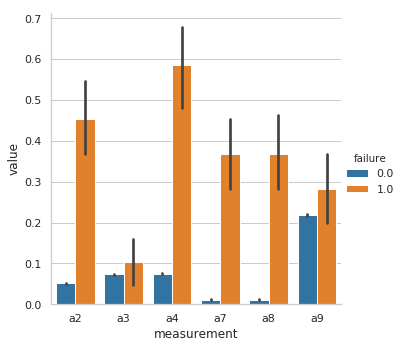

In [29]:
sns.catplot(x="measurement", y="value", hue="failure", kind="bar", data=subtemp_melt);

<a id="failhard"></a>
Looks to be true. When there is a failure, attributes 2, 4, 7, and 8 report much higher values than normal. This is not true of 1, 3, 5, 6, and 9. They should be correlated with failure then...

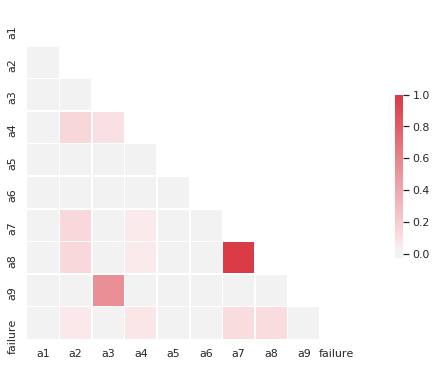

In [30]:
# Draw the heatmap with the mask and correct aspect ratio
corr = temp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

That is confidence building: a2, a4, a7, and a8 are weakly correlated with failure. Dig on A7==A8 in EDA.

## Date

In [25]:
# what are the dates representing?
dates = faults_df.date
dates.unique()

array([15001, 15002, 15003, 15004, 15005, 15006, 15007, 15008, 15009,
       15010, 15011, 15012, 15013, 15014, 15015, 15016, 15017, 15018,
       15019, 15020, 15021, 15022, 15023, 15024, 15025, 15026, 15027,
       15028, 15029, 15030, 15031, 15032, 15033, 15034, 15035, 15036,
       15037, 15038, 15039, 15040, 15041, 15042, 15043, 15044, 15045,
       15046, 15047, 15048, 15049, 15050, 15051, 15052, 15053, 15054,
       15055, 15056, 15057, 15058, 15059, 15060, 15061, 15062, 15063,
       15064, 15065, 15066, 15067, 15068, 15069, 15070, 15071, 15072,
       15073, 15074, 15075, 15076, 15077, 15078, 15079, 15080, 15081,
       15082, 15083, 15084, 15085, 15086, 15087, 15088, 15089, 15090,
       15091, 15092, 15093, 15094, 15095, 15096, 15097, 15098, 15099,
       15100, 15101, 15102, 15103, 15104, 15105, 15106, 15107, 15108,
       15109, 15110, 15111, 15112, 15113, 15114, 15115, 15116, 15117,
       15118, 15119, 15120, 15121, 15122, 15123, 15124, 15125, 15126,
       15127, 15128,

Dates look like an arbitrary sequence <a id="ordered"></a>

In [26]:
# is it sorted?
all(dates[i] <= dates[i+1] for i in range(len(dates)-1))

True

In [27]:
# so these are ordered, arbitrarily assigned date representations spaced by...
pd.Series(dates.unique()).diff().unique()

array([nan,  1.,  2.])

 Can't create datetime augmentations: the day of week, time of month, etc. may be important, but I don't know the baseline date, so cannot hardcode unknown information.

In [28]:
# add order val in case its useful
faults_df.insert(0, 'order', range(0, len(faults_df)))

As long as a date transformation is applied uniformly such that relative information is preserved, creating a datetime object with an arbitrary reference is okay.

In [29]:
faults_df['datetime'] = faults_df['date'].apply(lambda x: pd.to_datetime(x, unit='d'))

## Device

In [30]:
# isolate devices
devices = faults_df.device
devices.unique()

array(['S1F01085', 'S1F0166B', 'S1F01E6Y', ..., 'S1F02W1L', 'S1F02XLX',
       'S1F03499'], dtype=object)

In [31]:
# num of devices
len(devices.unique())

1168

In [32]:
# how many unique chars in each field of device name?
maxchars = max(devices.apply(lambda x: len(x)))
for nchar in range(0, maxchars):
    print('Char position {} :: num unique {}'.format(nchar,
                                                     len(devices.apply(lambda x: x[nchar]).unique())))

Char position 0 :: num unique 3
Char position 1 :: num unique 1
Char position 2 :: num unique 1
Char position 3 :: num unique 3
Char position 4 :: num unique 33
Char position 5 :: num unique 33
Char position 6 :: num unique 33
Char position 7 :: num unique 33


First four chars don't vary much; are there flavors of naming conventions, e.g. device classes?

In [33]:
# group chars and calc uniqueness
maxchars = max(devices.apply(lambda x: len(x)))
for nchars in range(1, maxchars):
    print('num chars {} :: num unique {}'.format(nchars,
                                              len(devices.apply(lambda x: x[:nchars]).unique())))

num chars 1 :: num unique 3
num chars 2 :: num unique 3
num chars 3 :: num unique 3
num chars 4 :: num unique 7
num chars 5 :: num unique 121
num chars 6 :: num unique 608
num chars 7 :: num unique 1104


There appear to be types of devices <a id="deviceclasses"></a>

In [34]:
# save the class1
faults_df['device_class1'] = faults_df.device.apply(lambda x: x[:3])

In [35]:
faults_df.device_class1.unique()

array(['S1F', 'W1F', 'Z1F'], dtype=object)

In [36]:
# remove class1 and look for more
sub_devices = devices.apply(lambda x: x[3:])
maxchars = max(sub_devices.apply(lambda x: len(x)))
for nchars in range(1, maxchars):
    print('num chars {} :: num unique {}'.format(nchars,
                                              len(sub_devices.apply(lambda x: x[:nchars]).unique())))

num chars 1 :: num unique 3
num chars 2 :: num unique 59
num chars 3 :: num unique 550
num chars 4 :: num unique 1101


In [37]:
# maybe 4th char is a submodel, generation...? small enough to encode
faults_df['device_class2'] = faults_df.device.apply(lambda x: x[3])

In [38]:
faults_df.device_class2.unique()

array(['0', '1', '2'], dtype=object)

In [39]:
# remove class1 and class2 and look for more
sub_devices = devices.apply(lambda x: x[4:])
maxchars = max(sub_devices.apply(lambda x: len(x)))
for nchars in range(1, maxchars):
    print('num chars {} :: num unique {}'.format(nchars,
                                              len(sub_devices.apply(lambda x: x[:nchars]).unique())))

num chars 1 :: num unique 33
num chars 2 :: num unique 514
num chars 3 :: num unique 1094


In [40]:
# lump remainder together
faults_df['device_class3'] = faults_df.device.apply(lambda x: x[4:])

In [41]:
faults_df.device_class3.unique()

array(['1085', '166B', '1E6Y', ..., '2W1L', '2XLX', '3499'], dtype=object)

In [42]:
# check that original device == device clases
assert sum(faults_df.device != faults_df.device_class1 + faults_df.device_class2 + faults_df.device_class3) == 0, "Device classification failed"

## Trends

In [ ]:
# Rohrshach approach: "interactively" pick random device that had a failure and look at attribute trends in time
while True:
    try:
        temp = faults_df[(faults_df.failure == 1)]
        rand_device = temp.sample(1).device.values[0]
        temp = faults_df[(faults_df.device == rand_device)]
        temp = temp.filter(regex='^a|date$')
        temp['a1cs'] = temp.a1.cumsum()
        scaler = preprocessing.MinMaxScaler()
        scaled_values = scaler.fit_transform(temp)
        temp.loc[:,:] = scaled_values
        temp.plot(x='date', style='.-')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(3)
    except KeyboardInterrupt:
        break

+ a1 looks unaggregated, a daily value possibly -- need to add a1 cumulative sum feature
+ All other attributes **_appear_** to be aggregates -- verify below
+ a2 and a4 stand-out as ramping up before failure -- need to add linear trend feature at each time step
+ A few attributes appear to be correlated -- verify below <a id="correlation"></a>

In [43]:
# add a1 cumulative sum feature
faults_df['a1_cumsum'] = faults_df.sort_values(by=['device','order']).groupby('device').a1.cumsum()

Do any values besides a1 go down?

In [44]:
# sort, diff, and count
cols = ['a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'failure']
temp = faults_df.sort_values(by=['device','order']).groupby('device')[cols].diff()
temp.lt(0).sum()

a2         6 
a3         0 
a4         0 
a5         24
a6         0 
a7         18
a8         18
a9         0 
failure    5 
dtype: int64

There are a choice few: a2, a5, a7, a8, failure. The failures in particular mean they've been cleared/reset. If these are aggregate attributes as they appear, then values that drop, even if rarely, are experiencing some kind of remediation/service.

In [50]:
# look at random example
a = random.choice(temp[(temp < 0).any(1)].index.tolist())
print(temp.loc[a])
print('\n*********************\n')
print('Look at index {}'.format(a))
b = faults_df[(faults_df.order == a)].device.values[0]
faults_df[(faults_df.device == b)]

a2         0.0  
a3         0.0  
a4         6.0  
a5         0.0  
a6         940.0
a7        -8.0  
a8        -8.0  
a9         0.0  
failure    1.0  
Name: 20817, dtype: float64

*********************

Look at index 20817


,order,date,device,a1,a2,a3,a4,a5,a6,a7,a8,a9,failure,uuid,datetime,device_class1,device_class2,device_class3,a1_cumsum
123,123,15001,S1F0LCTV,215846224,0,0,1,11,447025,0,0,0,0,84c0d7fcd448516f366aef58bb8ab36e,2011-01-27,S1F,0,LCTV,215846224
1286,1286,15002,S1F0LCTV,238613336,0,0,1,11,448353,0,0,0,0,3a22cb401b1a433db4b286d2655dd62e,2011-01-28,S1F,0,LCTV,454459560
2449,2449,15003,S1F0LCTV,14044072,0,0,1,11,449697,0,0,0,0,a40138ecf825a103823340d72ed2bf4c,2011-01-29,S1F,0,LCTV,468503632
3612,3612,15004,S1F0LCTV,36990704,0,0,1,11,451081,0,0,0,0,04846191411e4e0d904e53ae4ce1d47d,2011-01-30,S1F,0,LCTV,505494336
4773,4773,15005,S1F0LCTV,61513296,0,0,1,11,452406,0,0,0,0,3c3796641912ec4e28a0131608f5f4dd,2011-01-31,S1F,0,LCTV,567007632
5905,5905,15006,S1F0LCTV,87350048,0,0,1,11,453736,0,0,0,0,c02a606a87cfda7aeee4420036f7a7c5,2011-02-01,S1F,0,LCTV,654357680
6926,6926,15007,S1F0LCTV,117246408,0,0,1,11,455096,0,0,0,0,724900b6635bd86b9a56671e9f57c292,2011-02-02,S1F,0,LCTV,771604088
7723,7723,15008,S1F0LCTV,138173592,0,0,1,11,456424,0,0,0,0,ecb424e251ddd7ecd25d4d82eaa96d4f,2011-02-03,S1F,0,LCTV,909777680
8479,8479,15009,S1F0LCTV,163744768,0,0,1,11,457721,0,0,0,0,9d9cb0c606709ffdd4a7ab9a444a0da9,2011-02-04,S1F,0,LCTV,1073522448
9235,9235,15010,S1F0LCTV,183323688,0,0,1,11,459054,0,0,0,0,6ddb88307d70314c0c09efd250b9f352,2011-02-05,S1F,0,LCTV,1256846136


Need to manually add feature to capture service history:
+ Cumulative sum of a* service count
+ Cumulative sum of a* service magnitude

In [74]:
# service features
cols = ['a2', 'a5', 'a7', 'a8']
for col in cols:
    
    # create columns and init
    service_mag = col+'_service_mag'
    service_count = col+'_service_count'
    faults_df[service_mag] = 0
    faults_df[service_count] = 0
    
    # fill with diff and remove natural agg
    faults_df[service_mag] = faults_df.sort_values(by=['device', 'order']).groupby('device')[col].diff().fillna(0)
    faults_df.loc[faults_df[service_mag] > 0, service_mag] = 0
    
    # denote service count and cumsum
    faults_df.loc[faults_df[service_mag] < 0, service_count] = 1
    faults_df[service_count] = faults_df.sort_values(by=['device','order']).groupby('device')[service_count].cumsum()
    faults_df[service_mag] = faults_df.sort_values(by=['device','order']).groupby('device')[service_mag].cumsum()

In [76]:
# handle failure manually to deal with naming convention change   
col = 'failure'
service_mag = 'f_clear_mag'
service_count = 'f_clear_count'
faults_df[service_mag] = 0
faults_df[service_count] = 0

# fill with diff and remove natural agg
faults_df[service_mag] = faults_df.sort_values(by=['device', 'order']).groupby('device')[col].diff().fillna(0)
faults_df.loc[faults_df[service_mag] > 0, service_mag] = 0

# denote service count and cumsum
faults_df.loc[faults_df[service_mag] < 0, service_count] = 1
faults_df[service_count] = faults_df.sort_values(by=['device','order']).groupby('device')[service_count].cumsum()
faults_df[service_mag] = faults_df.sort_values(by=['device','order']).groupby('device')[service_mag].cumsum()

## Correlations

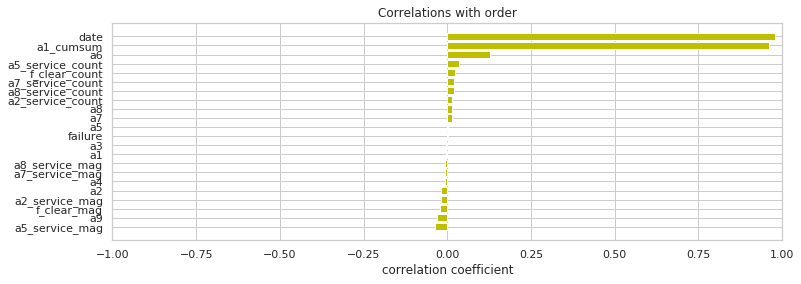

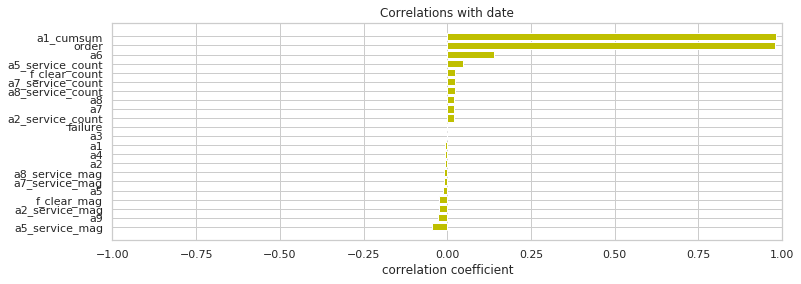

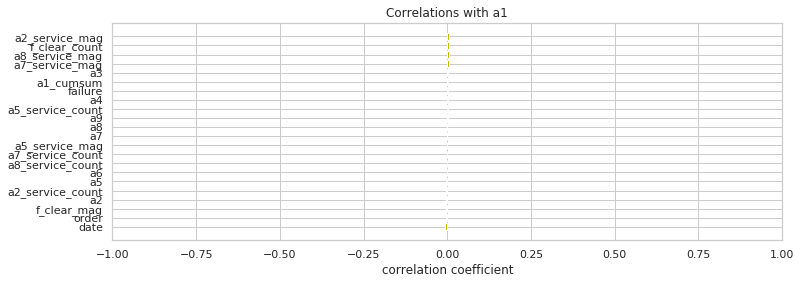

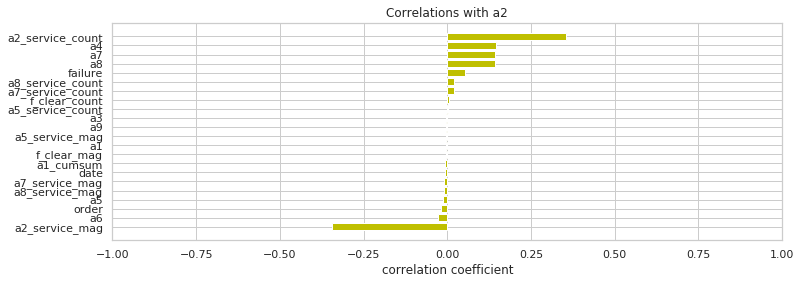

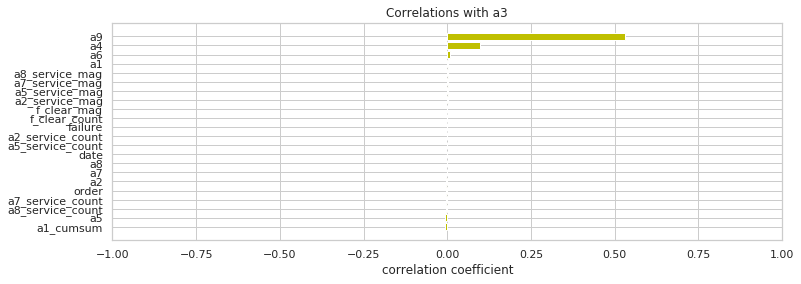

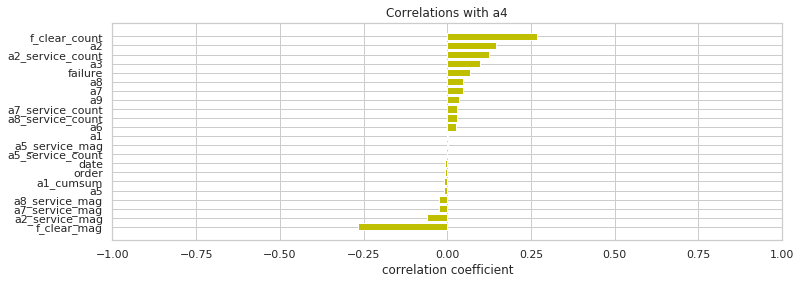

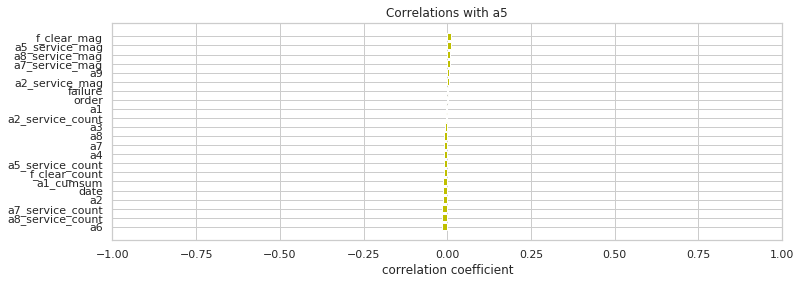

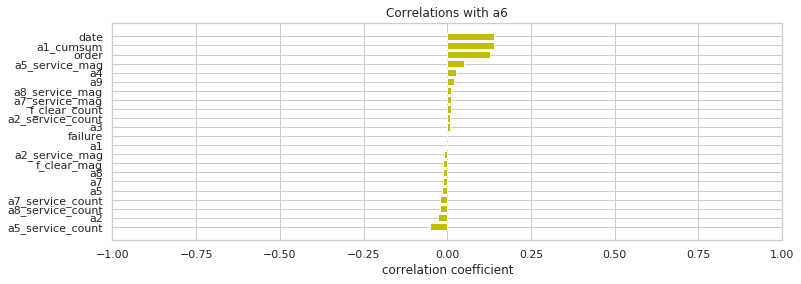

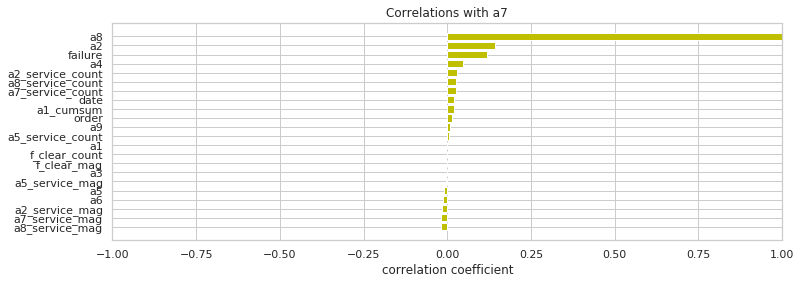

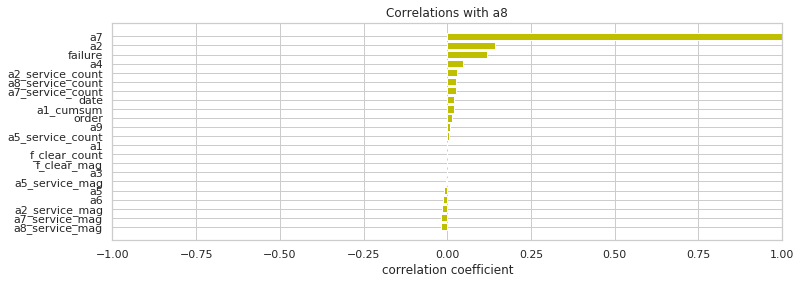

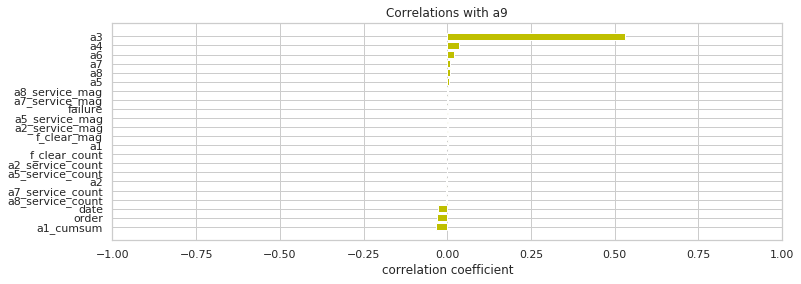

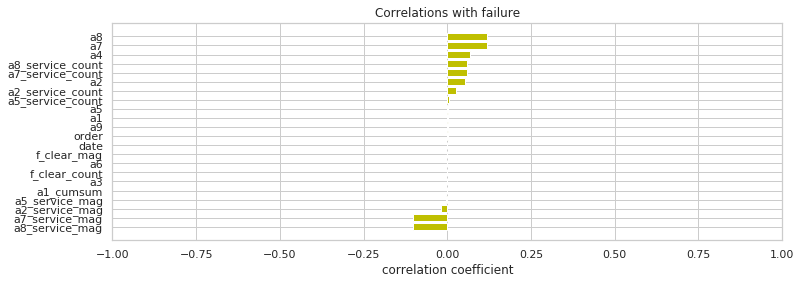

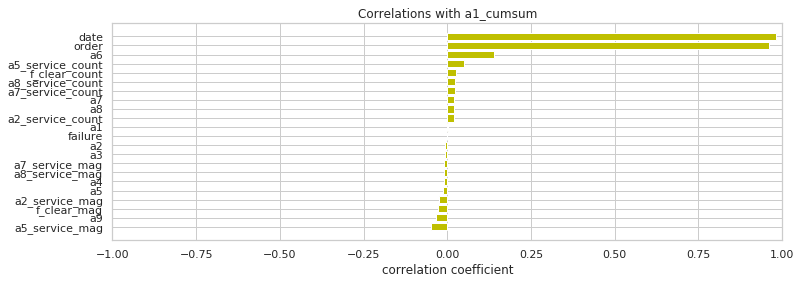

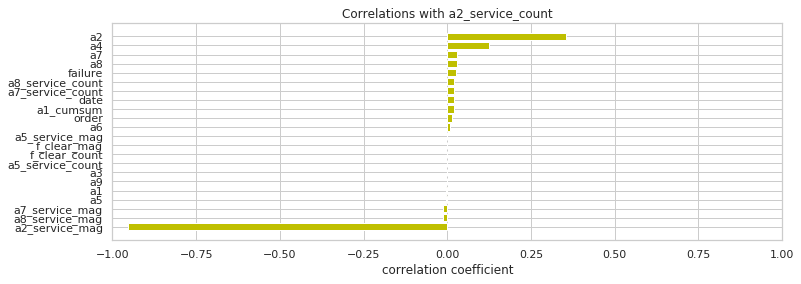

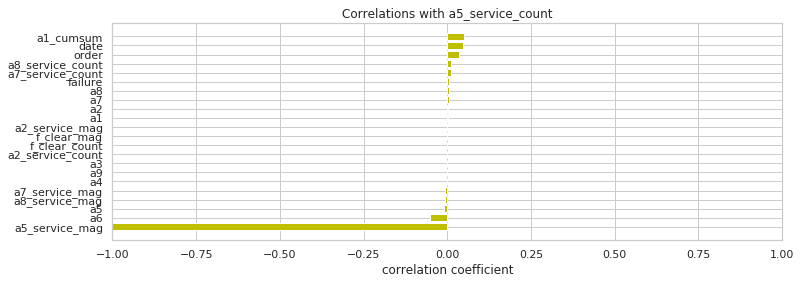

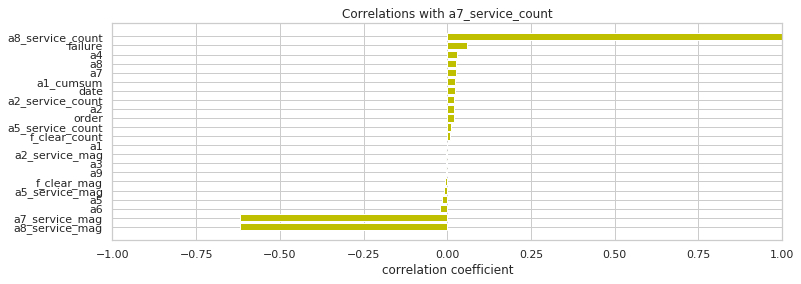

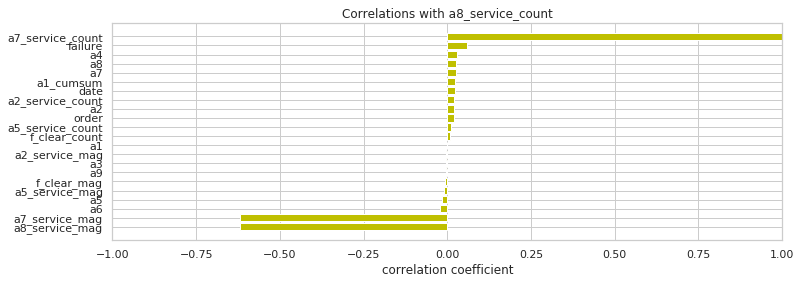

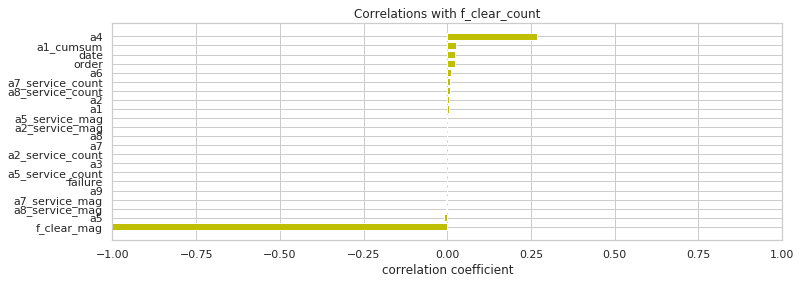

In [86]:
# look for correlations in numerical values
fields = [c for c in faults_df.columns if faults_df[c].dtype == 'int64']
visualize_correlations(faults_df, fields)

Indeed, some attributes are correlated, but A7 and A8 identical? <a id="a7a8"></a>

In [87]:
# are attribute 7 and 8 identical?
a7_str = ''.join(faults_df.a7.astype(str).values)
a7_hash = hashlib.md5(a7_str.encode('utf-8')).hexdigest()
a8_str = ''.join(faults_df.a8.astype(str).values)
a8_hash = hashlib.md5(a8_str.encode('utf-8')).hexdigest()
a7_hash == a8_hash

True

This is telemetry data, so maybe A7 and A8 are the same measurement with different units, e.g. imperial and metric

In [91]:
# 7 was my fav num as a kid (Boomer Esiason wore it for the Bengals)
# drop attr8
drop_cols = faults_df.filter(regex='^a8').columns.tolist()
faults_df.drop(drop_cols, inplace=True, axis=1)

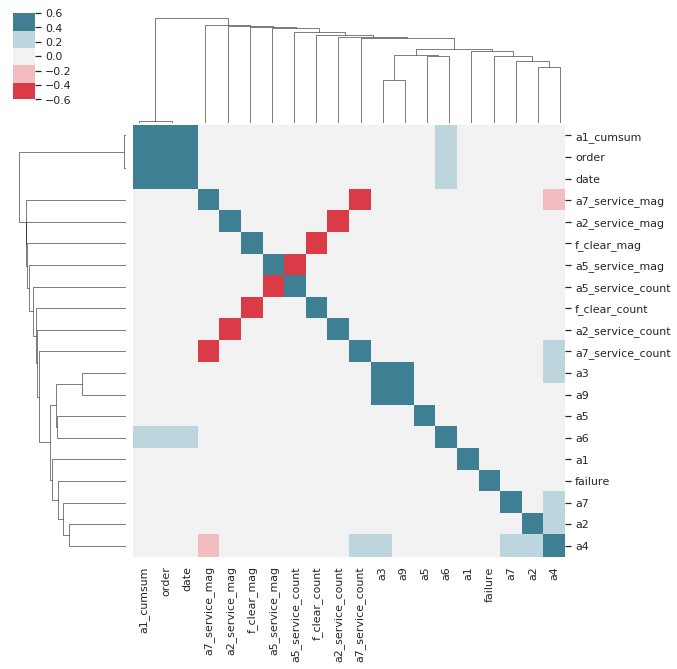

In [96]:
# correlation matrix
corrmat = faults_df.corr(method='spearman')

# Draw the heatmap using seaborn
sns.clustermap(corrmat, vmax=0.6, vmin=-0.6, square=True, cmap=sns_cmap);

Weak similarities, but nothing so glaring we should break attributes apart.

## Save

In [97]:
faults_df.to_pickle('faults_df.pkl')

# Feature Engineering

Normally, we would put in a great deal of effort and time with SME's to build even more features. For example, cumulative sums of aggregated values over time should be important, and we can engineer such a set of features with:
```python
for col in ['a'+str(i) for i in range(1,10)]:
    newcol = col+'_cumsum'
    try:
        faults_df.drop([newcol], axis=1, inplace=True)
    except:
        pass
    try:
        faults_df[newcol] = faults_df.groupby(['device'])[col].cumsum()
    except:
        continue
```

However, what about all the other stats terms that may have embeded info (count, max, min, mean, stddev, etc.). This is laborious to construct all those features. Alternatively, we could use a carefully tuned NN architecture to find those features via the model. This is also laborious. Another option: create an ensemble of models that extract predictive information from features it creates.

As a start, let's instead try deep feature synthesis and drive the problem to the left (data) rather than to the right (model). This can be accomplished with time series using [tensor deep feature synthesis][tdfs].

[tdfs]: https://docs.featuretools.com/automated_feature_engineering/handling_time.html#creating-a-3-dimensional-feature-tensor-using-multiple-cutoff-times-from-make-temporal-cutoffs

## Cut-off Times

In [98]:
# list of unique devices
unique_devices = faults_df.filter(regex='device').drop_duplicates()
instance_ids = sorted(unique_devices.device.tolist())

# capture start dates per device -- ORDER MATTERS
device_start_dates = faults_df.sort_values(by=['device']).groupby('device')['datetime'].min().tolist()

# capture end dates per device -- ORDER MATTERS
device_end_dates = faults_df.sort_values(by=['device']).groupby('device')['datetime'].max().tolist()

# create reference data frame
cutoffs = pd.DataFrame(
    {
        'device': instance_ids,
        'start': device_start_dates,
        'end': device_end_dates,
    }
)

In [99]:
# gut check on 100 random entries that reassembly of dates and devices match
for n in range(0, 100):
    
    # pick random device
    rand_device = faults_df.sample(1).device.values[0]
    
    # get original min/max dates in np datetime
    min_test = faults_df[(faults_df.device == rand_device)]['datetime'].min().to_datetime64()
    max_test = faults_df[(faults_df.device == rand_device)]['datetime'].max().to_datetime64()
    
    # get cutoff values
    rand_min = cutoffs[(cutoffs.device == rand_device)].start.values[0]
    rand_max = cutoffs[(cutoffs.device == rand_device)].end.values[0]
    
    # compare
    assert rand_min == min_test, 'Date mismatch'
    assert rand_max == max_test, 'Date mismatch'

In [100]:
# for each device, begin at start and increment by 1-day until the end
temporal_cutoffs = ft.make_temporal_cutoffs(
    instance_ids=cutoffs['device'],
    start=cutoffs['start'],
    cutoffs=cutoffs['end'],
    window_size='1d')

In [101]:
# save
temporal_cutoffs.to_pickle('temporal_cutoffs.pkl')

## Entity Creation

In [107]:
# Create new entityset
es = ft.EntitySet(id='timeseries')

In [108]:
# create entity for faults
es = es.entity_from_dataframe(
    entity_id='faults',
    dataframe=faults_df,
    index='uuid',
    time_index='datetime')

In [109]:
es.normalize_entity(base_entity_id='faults',
                    new_entity_id='unique_devices',
                    index='device',
                    make_time_index=True,
                    additional_variables=["device_class1", "device_class2", "device_class3"])

Entityset: timeseries
  Entities:
    faults [Rows: 124494, Columns: 23]
    unique_devices [Rows: 1168, Columns: 5]
  Relationships:
    faults.device -> unique_devices.device

In [110]:
es.entities

[Entity: faults
   Variables:
     uuid (dtype: index)
     order (dtype: numeric)
     date (dtype: numeric)
     device (dtype: id)
     a1 (dtype: numeric)
     a2 (dtype: numeric)
     a3 (dtype: numeric)
     a4 (dtype: numeric)
     a5 (dtype: numeric)
     a6 (dtype: numeric)
     a7 (dtype: numeric)
     a9 (dtype: numeric)
     failure (dtype: numeric)
     datetime (dtype: datetime_time_index)
     a1_cumsum (dtype: numeric)
     a2_service_mag (dtype: numeric)
     a2_service_count (dtype: numeric)
     a5_service_mag (dtype: numeric)
     a5_service_count (dtype: numeric)
     a7_service_mag (dtype: numeric)
     a7_service_count (dtype: numeric)
     f_clear_mag (dtype: numeric)
     f_clear_count (dtype: numeric)
   Shape:
     (Rows: 124494, Columns: 23), Entity: unique_devices
   Variables:
     device (dtype: index)
     device_class1 (dtype: categorical)
     device_class2 (dtype: categorical)
     device_class3 (dtype: categorical)
     first_faults_time (dtype: date

In [111]:
# save results
es.to_parquet('device_faults_entity_set')

Entityset: timeseries
  Entities:
    faults [Rows: 124494, Columns: 23]
    unique_devices [Rows: 1168, Columns: 5]
  Relationships:
    faults.device -> unique_devices.device

## Deep Feature Synthesis

In [13]:
# reload data
es = ft.read_parquet('device_faults_entity_set')
temporal_cutoffs = pd.read_pickle('temporal_cutoffs.pkl')
faults_df = pd.read_pickle('faults_df.pkl')

The below step can be parallelized using Dask (`n_jobs=-1`) since it's an embarassingly parallel problem due to independence:

$device_i \perp cutoff_j \perp feature matrix_j$

In [14]:
# reminder of the dfs primitives
ft.primitives.list_primitives()

,name,type,description
0,num_true,aggregation,Finds the number of 'True' values in a boolean.
1,last,aggregation,Returns the last value.
2,mode,aggregation,Finds the most common element in a categorical feature.
3,num_unique,aggregation,Returns the number of unique categorical variables.
4,std,aggregation,Finds the standard deviation of a numeric feature ignoring null values.
5,min,aggregation,Finds the minimum non-null value of a numeric feature.
6,mean,aggregation,Computes the average value of a numeric feature.
7,max,aggregation,Finds the maximum non-null value of a numeric feature.
8,skew,aggregation,Computes the skewness of a data set.
9,trend,aggregation,Calculates the slope of the linear trend of variable overtime.


In [15]:
# primitive selections
agg_primitives=["mean", "median", "mode",
                "max", "min", "std", "skew",
                "count", "trend",
                "last", "time_since_last", "avg_time_between"]

# not obvious that transforms needed
# options, if so: "percentile", "time_since_previous", "multiply", "mod", "add", "subtract", "diff", "divide"
trans_primitives=[]

In [16]:
# don't waste time on data that isn't relevant
ignore_variables = {'faults': ['uuid',
                               'order',
                               'date',
                               'device_class1',
                               'device_class2',
                               'device_class3',
                               'failure']
                   }

In [17]:
# create the feature tensor
feature_tensor, feature_defs = ft.dfs(
    entityset=es,
    target_entity='unique_devices',
    cutoff_time=temporal_cutoffs,
    cutoff_time_in_index=True,
    agg_primitives=agg_primitives,
    trans_primitives=trans_primitives,
    ignore_variables=ignore_variables,
    max_depth=1,
    max_features=-1,
    chunk_size="cutoff time",
    n_jobs=-1,
    verbose=True)

Built 141 features
EntitySet scattered to workers in 4.347 seconds
Elapsed: 08:59 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 306/306 chunks


Exception ignored in: <generator object add_client at 0x7fd184c3a8e0>
RuntimeError: generator ignored GeneratorExit
Future exception was never retrieved
future: <Future finished exception=StreamClosedError('Stream is closed',)>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/tcpclient.py", line 112, in on_connect_done
    stream = future.result()
tornado.iostream.StreamClosedError: Stream is closed
Future exception was never retrieved
future: <Future finished exception=StreamClosedError('Stream is closed',)>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/tcpclient.py", line 112, in on_connect_done
    stream = future.result()
tornado.iostream.StreamClosedError: Stream is closed
Future exception was never retrieved
future: <Future finished exception=StreamClosedError('Stream is closed',)>
Traceback (most recent call last):
  File "/home/ubu

In [19]:
# save intermediate output
hdf_file = 'raw_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
save_hdf5(feature_tensor, hdf_file, table_name)

## QA

In [20]:
# clean-up data and don't disturb original
dfs_qa = feature_tensor.copy().reset_index()
dfs_qa.rename(columns={'time':'datetime'}, inplace=True)

In [21]:
# data in == data out
orig_len = len(dfs_qa)
new_len = len(feature_tensor)
assert orig_len == new_len, 'There is new or missing data'

The '1d' time windows in DFS automatically create steps in time where there may not be data, e.g.:
* original: [1 2 3 4 8 9]
* dfs: [1 2 3 4 **_5 6 7_** 8 9]

There are added values. Simply joing back against original dataframe (need to do anyways) fixes this.

In [22]:
# per problem statement, one device per day?
check = dfs_qa.datetime.astype(str) + dfs_qa.device.astype(str)
assert len(check) == len(check.drop_duplicates()), 'More than one device per day'

In [23]:
# rid ourselves of the junk datetime features due to arbitrary date assignment
dropcols = dfs_qa.filter(regex='DAY|MONTH|WEEKDAY|YEAR').columns.tolist()
nunique = dfs_qa.apply(pd.Series.nunique)
dropcols.extend(nunique[nunique == 1].index.tolist())
list(set(dropcols))

['MIN(faults.f_clear_count)',
 'MIN(faults.a5_service_count)',
 'MIN(faults.a7_service_count)',
 'MAX(faults.a5_service_mag)',
 'MIN(faults.a2_service_count)',
 'MAX(faults.a7_service_mag)',
 'MAX(faults.f_clear_mag)',
 'MAX(faults.a2_service_mag)',
 'MEDIAN(faults.f_clear_count)',
 'MEDIAN(faults.f_clear_mag)']

In [24]:
# drop them
dfs_qa.drop(dropcols, axis=1, inplace=True)

In [25]:
# merge dfs with original faults
faults_dfs_df = pd.merge(faults_df, dfs_qa, on=['device','datetime'], suffixes=('', '_y'))
assert len(faults_dfs_df) == len(faults_df), 'Something went wrong in merge'

In [26]:
# some duplicate columns in join
dropcols = faults_dfs_df.filter(regex='_y')
faults_dfs_df.drop(dropcols, axis=1, inplace=True)

In [27]:
# 10 min runtime for above on laptop, save output just in case
hdf_file = 'qa_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
save_hdf5(faults_dfs_df, hdf_file, table_name, format='table')

# Training Data

In [28]:
# reload data
hdf_file = 'qa_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
Xy = pd.read_hdf(hdf_file, table_name)
feature_names = Xy.columns.tolist()

In [29]:
# some dfs are uniform
nunique = Xy.apply(pd.Series.nunique)
dropcols = nunique[nunique == 1].index.tolist()
sorted(dropcols)

[]

In [30]:
# remove uniform cols
if len(dropcols) > 0:
    Xy.drop(dropcols, axis=1, inplace=True)

In [31]:
Xy.head()

,order,date,device,a1,a2,a3,a4,a5,a6,a7,...,LAST(faults.a2_service_mag),LAST(faults.a2_service_count),LAST(faults.a5_service_mag),LAST(faults.a5_service_count),LAST(faults.a7_service_mag),LAST(faults.a7_service_count),LAST(faults.f_clear_mag),LAST(faults.f_clear_count),TIME_SINCE_LAST(faults.datetime),AVG_TIME_BETWEEN(faults.datetime)
0,0,15001,S1F01085,215630672,56,0,52,6,407438,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,NaN
1,1,15001,S1F0166B,61370680,0,3,0,6,403174,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,NaN
2,2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,NaN
3,3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,NaN
4,4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,NaN


In [32]:
feature_names

['order',
 'date',
 'device',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a7',
 'a9',
 'failure',
 'uuid',
 'datetime',
 'device_class1',
 'device_class2',
 'device_class3',
 'a1_cumsum',
 'a2_service_mag',
 'a2_service_count',
 'a5_service_mag',
 'a5_service_count',
 'a7_service_mag',
 'a7_service_count',
 'f_clear_mag',
 'f_clear_count',
 'MEAN(faults.a1)',
 'MEAN(faults.a2)',
 'MEAN(faults.a3)',
 'MEAN(faults.a4)',
 'MEAN(faults.a5)',
 'MEAN(faults.a6)',
 'MEAN(faults.a7)',
 'MEAN(faults.a9)',
 'MEAN(faults.a1_cumsum)',
 'MEAN(faults.a2_service_mag)',
 'MEAN(faults.a2_service_count)',
 'MEAN(faults.a5_service_mag)',
 'MEAN(faults.a5_service_count)',
 'MEAN(faults.a7_service_mag)',
 'MEAN(faults.a7_service_count)',
 'MEAN(faults.f_clear_mag)',
 'MEAN(faults.f_clear_count)',
 'MEDIAN(faults.a1)',
 'MEDIAN(faults.a2)',
 'MEDIAN(faults.a3)',
 'MEDIAN(faults.a4)',
 'MEDIAN(faults.a5)',
 'MEDIAN(faults.a6)',
 'MEDIAN(faults.a7)',
 'MEDIAN(faults.a9)',
 'MEDIAN(faults.a1_cumsum)',
 'MEDIAN

In [33]:
# columns to encode
encode_cols = [
    'device_class1',
    'device_class2',
    'device_class3'
]

In [34]:
# one-hot encode the categoricals
Xy = pd.concat([Xy, pd.get_dummies(Xy[encode_cols])], axis=1)
Xy.drop(encode_cols, axis=1, inplace=True)

In [35]:
# junk features
dropcols = Xy.filter(regex='MODE\(faults.device_class')
Xy.drop(dropcols, axis=1, inplace=True)

In [36]:
# save intermediate output
hdf_file = 'model_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
save_hdf5(Xy, hdf_file, table_name)

# Modeling

This is a gnarly imbalanced class problem. Traditional options:
* Under-sample majority class: viable option since time-dependent values are encoded at every time step.
* Stratified resampling: viable option via xgboost.
* Over-sample minority class: this is time series data, so arbitrarily throwing out samples potentially removes valuable information about aggregations or leading indicators to failure.
* Synthesis: No. I intensely dislike manufacturing data unless there are strong underlying laws/principles, e.g. in physics, which constrain the fake data.

## Data Prep

In [37]:
# reload data from prior run as a quick start
faults_df = pd.read_pickle('faults_df.pkl')
hdf_file = 'model_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
Xy = pd.read_hdf(hdf_file, table_name)

In [38]:
# ID cols to use in modeling
ignore = ['date', 'device', 'datetime']
ignore.extend(Xy.filter(regex='failure').columns)  # anything with failure info
predicting = 'failure'
predictors = [c for c in Xy.columns if (c != predicting and c not in ignore)]

# isolate y from X
y = Xy[predicting]
X = Xy[predictors]

# split data into train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=7)

# remove uuid and track as index
idx_train = X_train.uuid.values
idx_test = X_test.uuid.values
X_train.drop('uuid', axis=1, inplace=True)
X_test.drop('uuid', axis=1, inplace=True)
feature_names = X_train.columns.values
assert set(feature_names) == set(X_test.columns.values), 'Train/Test feature name mismatch'

## xgboost

In [39]:
# make the train test vers for xgb
dtrain = xgb.DMatrix(X_train, y_train, feature_names=feature_names, nthread=-1)
dtest = xgb.DMatrix(X_test, y_test, feature_names=feature_names, nthread=-1)

### Naive Model

In [41]:
# define a naive model
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'max_bin': 1024,
    'max_leaves': 255,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'num_boost_round': 500,
    'objective': 'binary:logistic',
    'silent': 1,
    'seed': 0,
    'grow_policy': 'depthwise',
    'n_gpus': 1
}
model = xgb.train(xgb_params, dtrain)

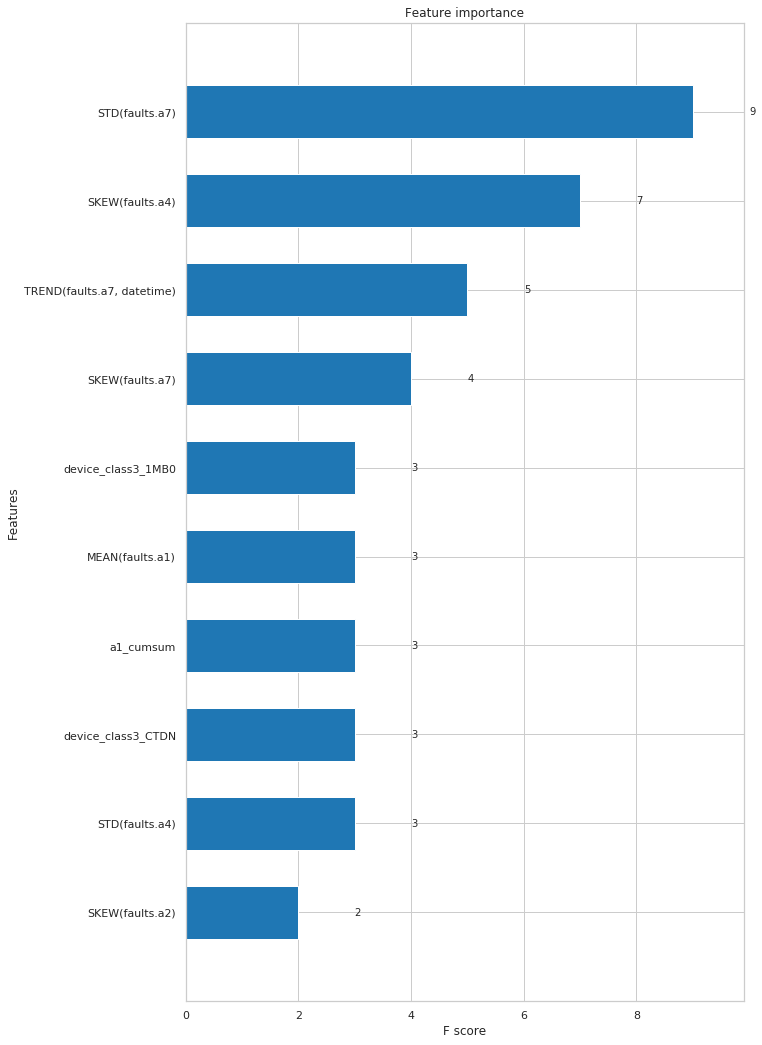

In [42]:
# plot the important features #
fig, ax = plt.subplots(figsize=(10, 18))
xgb.plot_importance(model, height=0.6, ax=ax, max_num_features=10)
fig.savefig('feature_importance.png', bbox_inches='tight', pad_inches=1)
plt.show()

<a id="#naivemodel"></a>
Is a7 really that important?

In [44]:
# prediction on test set
y_pred = model.predict(dtest)

In [49]:
# let's see if this makes sense
temp = faults_df.filter(regex='^a.$|failure')
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(temp)
temp.loc[:,:] = scaled_values
temp_melt = pd.melt(temp, "failure", var_name="measurement")
temp_melt.groupby(['measurement', 'failure']).std()

value
measurement failure          
a1          0.0      0.288607
            1.0      0.284269
a2          0.0      0.033024
            1.0      0.197078
a3          0.0      0.007454
            1.0      0.001266
a4          0.0      0.013304
            1.0      0.116142
a5          0.0      0.164365
            1.0      0.160281
a6          0.0      0.143869
            1.0      0.149966
a7          0.0      0.007882
            1.0      0.140665
a9          0.0      0.010238
            1.0      0.008205

Standard deviation for a7 is unusually larger when there's a failure.

### Tuned Model

In [57]:
# control for class imbalance
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

# model params
params = {
    'max_depth': 9,
    'min_child_weight': 100,
    'subsample': 0.9,  # random sample %
    'colsample_bytree': 0.4,  # random col %
    'eta': 0.01,  # learning rate
    'reg_alpha': 0.5,  # L1 reg
    'lambda': 0.95,  # L2 reg
    'gamma': 0.1,  # loss split
    'seed': 6,
    'n_estimators': 1000,
    'scale_pos_weight': ratio,  # VERY IMPORTANT FOR THIS PARTICULAR PROBLEM
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'grow_policy': 'depthwise'
}

# train the model
model = train_xgb_model(X_train, y_train, params, kfolds=10)

Working on k-fold 0...
Splitting data
Converting data to xgb format
Modeling
[0]	train-auc:0.963634	cv-auc:0.706736
Multiple eval metrics have been passed: 'cv-auc' will be used for early stopping.

Will train until cv-auc hasn't improved in 300 rounds.
[200]	train-auc:0.999639	cv-auc:0.741863
[400]	train-auc:0.999787	cv-auc:0.826566
[600]	train-auc:0.999855	cv-auc:0.806941
Stopping. Best iteration:
[397]	train-auc:0.999784	cv-auc:0.828143

Done.
Working on k-fold 1...
Splitting data
Converting data to xgb format
Modeling
[0]	train-auc:0.953478	cv-auc:0.745394
Multiple eval metrics have been passed: 'cv-auc' will be used for early stopping.

Will train until cv-auc hasn't improved in 300 rounds.
[200]	train-auc:0.999738	cv-auc:0.868661
Stopping. Best iteration:
[2]	train-auc:0.997548	cv-auc:0.91282

Done.
Working on k-fold 2...
Splitting data
Converting data to xgb format
Modeling
[0]	train-auc:0.97916	cv-auc:0.823065
Multiple eval metrics have been passed: 'cv-auc' will be used for ea

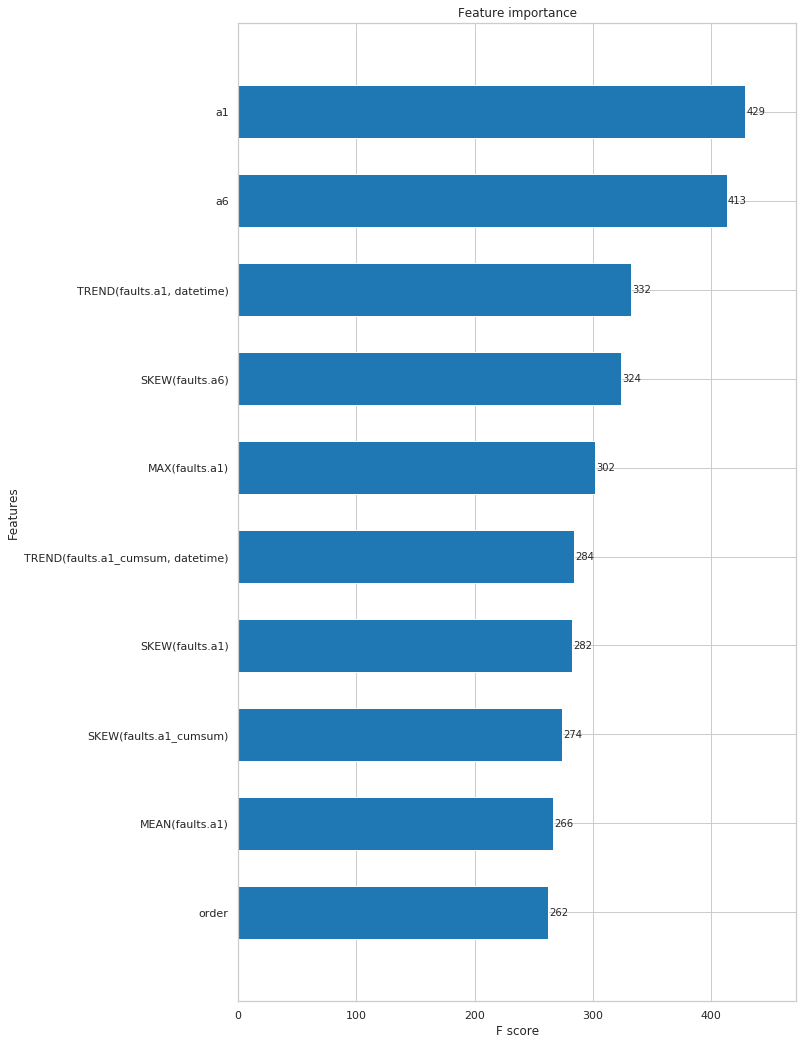

In [59]:
# feature importance plot
fig, ax = plt.subplots(figsize=(10, 18))
xgb.plot_importance(model, height=0.6, ax=ax, max_num_features=10)
fig.savefig('feature_importance.png', bbox_inches='tight', pad_inches=1)

In [60]:
# predict
y_pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)

In [66]:
# binary predictions
target_names = ['no fail', 'fail']
for prob_thresh in np.arange(0.48, 0.5, 0.0001):
    y_pred_binary = [1 if x > prob_thresh else 0 for x in y_pred ]
    print(prob_thresh)
    print(metrics.classification_report(y_test, y_pred_binary, target_names=target_names))

0.48
             precision    recall  f1-score   support

    no fail       1.00      0.83      0.91     41040
       fail       0.00      0.77      0.01        44

avg / total       1.00      0.83      0.90     41084

0.48009999999999997
             precision    recall  f1-score   support

    no fail       1.00      0.83      0.91     41040
       fail       0.00      0.77      0.01        44

avg / total       1.00      0.83      0.90     41084

0.48019999999999996
             precision    recall  f1-score   support

    no fail       1.00      0.83      0.91     41040
       fail       0.00      0.77      0.01        44

avg / total       1.00      0.83      0.90     41084

0.48029999999999995
             precision    recall  f1-score   support

    no fail       1.00      0.83      0.91     41040
       fail       0.00      0.77      0.01        44

avg / total       1.00      0.83      0.91     41084

0.48039999999999994
             precision    recall  f1-score   support

 

0.4835999999999996
             precision    recall  f1-score   support

    no fail       1.00      0.92      0.96     41040
       fail       0.01      0.73      0.02        44

avg / total       1.00      0.92      0.96     41084

0.4836999999999996
             precision    recall  f1-score   support

    no fail       1.00      0.92      0.96     41040
       fail       0.01      0.70      0.02        44

avg / total       1.00      0.92      0.96     41084

0.48379999999999956
             precision    recall  f1-score   support

    no fail       1.00      0.93      0.96     41040
       fail       0.01      0.68      0.02        44

avg / total       1.00      0.93      0.96     41084

0.48389999999999955
             precision    recall  f1-score   support

    no fail       1.00      0.93      0.96     41040
       fail       0.01      0.61      0.02        44

avg / total       1.00      0.93      0.96     41084

0.48399999999999954
             precision    recall  f1-score

0.4871999999999992
             precision    recall  f1-score   support

    no fail       1.00      0.95      0.97     41040
       fail       0.01      0.59      0.02        44

avg / total       1.00      0.95      0.97     41084

0.4872999999999992
             precision    recall  f1-score   support

    no fail       1.00      0.95      0.97     41040
       fail       0.01      0.59      0.02        44

avg / total       1.00      0.95      0.97     41084

0.48739999999999917
             precision    recall  f1-score   support

    no fail       1.00      0.95      0.97     41040
       fail       0.01      0.59      0.02        44

avg / total       1.00      0.95      0.97     41084

0.48749999999999916
             precision    recall  f1-score   support

    no fail       1.00      0.95      0.97     41040
       fail       0.01      0.59      0.02        44

avg / total       1.00      0.95      0.97     41084

0.48759999999999915
             precision    recall  f1-score

0.4907999999999988
             precision    recall  f1-score   support

    no fail       1.00      0.95      0.98     41040
       fail       0.01      0.59      0.03        44

avg / total       1.00      0.95      0.98     41084

0.4908999999999988
             precision    recall  f1-score   support

    no fail       1.00      0.95      0.98     41040
       fail       0.01      0.59      0.03        44

avg / total       1.00      0.95      0.98     41084

0.49099999999999877
             precision    recall  f1-score   support

    no fail       1.00      0.95      0.98     41040
       fail       0.01      0.59      0.03        44

avg / total       1.00      0.95      0.98     41084

0.49109999999999876
             precision    recall  f1-score   support

    no fail       1.00      0.96      0.98     41040
       fail       0.01      0.59      0.03        44

avg / total       1.00      0.95      0.98     41084

0.49119999999999875
             precision    recall  f1-score

0.4943999999999984
             precision    recall  f1-score   support

    no fail       1.00      0.97      0.99     41040
       fail       0.02      0.48      0.04        44

avg / total       1.00      0.97      0.99     41084

0.4944999999999984
             precision    recall  f1-score   support

    no fail       1.00      0.97      0.99     41040
       fail       0.02      0.48      0.04        44

avg / total       1.00      0.97      0.99     41084

0.4945999999999984
             precision    recall  f1-score   support

    no fail       1.00      0.97      0.99     41040
       fail       0.02      0.48      0.04        44

avg / total       1.00      0.97      0.99     41084

0.49469999999999836
             precision    recall  f1-score   support

    no fail       1.00      0.97      0.99     41040
       fail       0.02      0.48      0.04        44

avg / total       1.00      0.97      0.99     41084

0.49479999999999835
             precision    recall  f1-score 

0.497999999999998
             precision    recall  f1-score   support

    no fail       1.00      0.97      0.99     41040
       fail       0.02      0.48      0.04        44

avg / total       1.00      0.97      0.99     41084

0.498099999999998
             precision    recall  f1-score   support

    no fail       1.00      0.97      0.99     41040
       fail       0.02      0.48      0.04        44

avg / total       1.00      0.97      0.99     41084

0.498199999999998
             precision    recall  f1-score   support

    no fail       1.00      0.97      0.99     41040
       fail       0.02      0.48      0.04        44

avg / total       1.00      0.97      0.99     41084

0.49829999999999797
             precision    recall  f1-score   support

    no fail       1.00      0.97      0.99     41040
       fail       0.02      0.48      0.04        44

avg / total       1.00      0.97      0.99     41084

0.49839999999999796
             precision    recall  f1-score   s

In [114]:
# arbitrarily select threshold
y_pred_binary = [1 if x >= 0.4836 else 0 for x in y_pred ]

Text(0.5,1,'Binary Precision-Recall: Avg Precision=0.04')

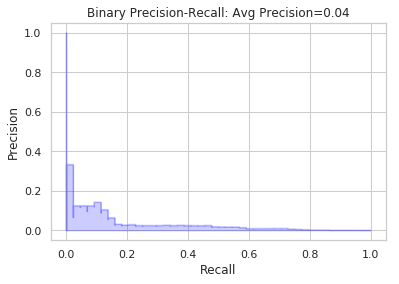

In [115]:
# visualize prec-recall
average_precision = metrics.average_precision_score(y_test, y_pred)
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Binary Precision-Recall: Avg Precision={0:0.2f}'.format(average_precision))

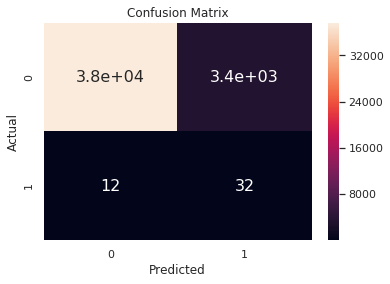

In [116]:
# cm
ax = sns.heatmap(metrics.confusion_matrix(y_test, y_pred_binary), annot=True, annot_kws={"size": 16});
ax.set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');

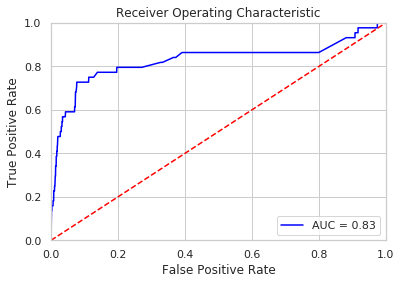

In [117]:
# roc
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## AutoML

In [120]:
import h2o
from h2o.automl import H2OAutoML

In [121]:
h2o.init()
h2o.cluster().show_status()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpec07vqpa
  JVM stdout: /tmp/tmpec07vqpa/h2o_ubuntu_started_from_python.out
  JVM stderr: /tmp/tmpec07vqpa/h2o_ubuntu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,15 hours and 12 minutes
H2O cluster name:,H2O_from_python_ubuntu_k9p34y
H2O cluster total nodes:,1
H2O cluster free memory:,6.761 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,01 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,15 hours and 12 minutes
H2O cluster name:,H2O_from_python_ubuntu_k9p34y
H2O cluster total nodes:,1
H2O cluster free memory:,6.761 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


In [123]:
train_df_h2o = h2o.H2OFrame(Xy)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [124]:
train, test, valid = train_df_h2o.split_frame(ratios=[0.7, 0.15])

In [125]:
# Identify predictors and response
x = train[predictors].columns
y = predicting

In [ ]:
# Run AutoML
aml = H2OAutoML(max_runtime_secs=3600, balance_classes=True)
aml.train(x=x,
          y=y,
          training_frame=train,
          validation_frame=valid,
          leaderboard_frame=test)#,
          #class_sampling_factors=
          #max_after_balance_size=)

AutoML progress: |████

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard

In [ ]:
lb

In [ ]:
# The leader model is stored here
aml.leader

AutoML "likes" SKEW(a4) like xgboost did.

In [ ]:
# predictions
y_pred = aml.leader.predict(test)

## FFNN

Why not?

In [ ]:
# define I/O
input_size = len(featurenames)
output_size = 2

# build model
x = Input(shape=(input_size,))
layer1 = Dense(25, activation='relu')(x)
layer2 = Dense(10)(layer1)
layer3 = Dense(35)(layer2)
layer4 = Dense(10)(layer3)
layer5 = Dense(25, activation=None)(layer4)
layer6 = Dense(output_size)(layer5)
model = Model(x, layer6)
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(0.001),
    metrics=[sensitivity, specificity]
)

In [ ]:
# weight the class imbalance
trade_off = 0.5  # for f-score
class_weight={
    0: 1,
    1: ratio * t
}

In [ ]:
batch_size = len(X_train) / 14
model.fit(X_train,
          y_train,
          nb_epoch=500,
          batch_size=batch_size,
          class_weight=class_weight)

# Scratch